In [1]:
#%pip install numpy matplotlib zarr xarray ipykernel gcsfs fsspec dask cartopy ocf-blosc2 torchinfo
#%pip install -U doxa-cli

Note: you may need to restart the kernel to use updated packages.


  Using cached requests-2.26.0-py2.py3-none-any.whl (62 kB)
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: doxa-cli
    Found existing installation: doxa-cli 0.1.5
    Uninstalling doxa-cli-0.1.5:
      Successfully uninstalled doxa-cli-0.1.5
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anaconda-project 0.11.1 requires ruamel-yaml, which is not installed.
translate-json 0.0.2 requires certifi==2021.5.30, but you have certifi 2023.5.7 which is incompatible.
translate-json 0.0.2 requires idna==3.2; python_version >= "3", but you have idna 2.10 which is incompatible.
osmnx 1.9.1 requires requests>=2.27, but you have requests 2.26.0 which is incompatible.
conda-repo-cli 1.0.20 requires clyent==1.2.1, but you have clyent 1.2.2 which is incompatible.
conda-repo-cli 1.0.20 requires nbformat==5.4.0, but you have nbformat 5.5.0 which is incompatible.
conda-repo-cli 1.0.20 requires requests==2.28.1, but you have requests 2.26.0 which is incompatible.


## Importing packages

Here, we import a number of packages we will need to train our first model.

In [6]:
!pip install pvlib

     --------------------------------------- 29.5/29.5 MB 10.9 MB/s eta 0:00:00


In [1]:
import os
from datetime import datetime, time, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import xarray as xr
from ocf_blosc2 import Blosc2
from torch.utils.data import DataLoader, IterableDataset
from torchinfo import summary
import json
import geopandas as gpd
import seaborn as sns
from scipy.ndimage import zoom
import numpy as np
import h5py
import pvlib 
import math
import torch.nn.functional as F

plt.rcParams["figure.figsize"] = (20, 12)

c:\Users\james\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\james\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Run this block to install all data

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device
if not os.path.exists("submission"):
     os.makedirs("submission", exist_ok=True)
     #Installing locally means you do not need to rerun this each time you restart the notebook
     !curl -L https://raw.githubusercontent.com/climatehackai/getting-started-2023/main/submission/competition.py --output submission/competition.py
     !curl -L https://raw.githubusercontent.com/climatehackai/getting-started-2023/main/submission/doxa.yaml --output submission/doxa.yaml
     !curl -L https://raw.githubusercontent.com/climatehackai/getting-started-2023/main/submission/model.py --output submission/model.py
     !curl -L https://raw.githubusercontent.com/climatehackai/getting-started-2023/main/submission/run.py --output submission/run.py
     !curl -L https://raw.githubusercontent.com/climatehackai/getting-started-2023/main/indices.json --output indices.json
if not os.path.exists("data"):
    os.makedirs("data/pv/2020", exist_ok=True)
    os.makedirs("data/satellite-hrv/2020", exist_ok=True)

    !curl -L https://huggingface.co/datasets/climatehackai/climatehackai-2023/resolve/main/pv/metadata.csv --output data/pv/metadata.csv
    !curl -L https://huggingface.co/datasets/climatehackai/climatehackai-2023/resolve/main/pv/2020/7.parquet --output data/pv/2020/7.parquet
    !curl -L https://huggingface.co/datasets/climatehackai/climatehackai-2023/resolve/main/satellite-hrv/2020/7.zarr.zip --output data/satellite-hrv/2020/7.zarr.zip
pv = pd.read_parquet("data/pv/2020/7.parquet").drop("generation_wh", axis=1)
#The parquet data here is similar to a dataframe. The "power" is the column with the other data types being indexes. The data is shaped with each timestamp being its own sub frame with the sites having their corresponding power (I think this is the % of their total possible yield).  
hrv = xr.open_dataset(
    "data/satellite-hrv/2020/7.zarr.zip", engine="zarr", chunks="auto"
)
#The way that this works is that it stores the image as a vector. The vectors are stored as an array of vectors. These then have a timestamp, as we only have one channel the array is a 1D set of vectors with the dimension being time. Read this to help you understand how this is being stored https://tutorial.xarray.dev/fundamentals/01_datastructures.html
# To access I have included some examples below
#The float value (float16-float64) shows the precision with which data is stored. Later on it is important to make sure that when you are feeding in data into the model that the float type matches between data types, this currently is not a problem when only using the HRV data. I am not yet sure if this will be a problem when using the NWP data.
with open("indices.json") as f:
    site_locations = {
        data_source: {
            int(site): (int(location[0]), int(location[1]))
            for site, location in locations.items()
        }
        for data_source, locations in json.load(f).items()
    }
if not os.path.exists("data"):
    os.makedirs("data/pv/2020", exist_ok=True)
    os.makedirs("data/satellite-hrv/2020", exist_ok=True)

    !curl -L https://huggingface.co/datasets/climatehackai/climatehackai-2023/resolve/main/pv/metadata.csv --output data/pv/metadata.csv
    !curl -L https://huggingface.co/datasets/climatehackai/climatehackai-2023/resolve/main/pv/2020/7.parquet --output data/pv/2020/7.parquet
    !curl -L https://huggingface.co/datasets/climatehackai/climatehackai-2023/resolve/main/satellite-hrv/2020/7.zarr.zip --output data/satellite-hrv/2020/7.zarr.zip 

## For finding the average distance between a site and its nearest neighbour

In [4]:
#Note that not all the sites in the PV sets line up with the sites in the indices set later on so not all of them can be plotted using a CRS system as the pv object has the CRS coordinates for some and not all of the sites. This is not an issue for the model but is for plotting all the sites on a mao should we want to include this.
####################This block is used for plotting, you do not need to run this block to run the models############################
#here I am getting the long and lat for all of our sites in the data set so that they can be plotted
pv_kwh = pd.read_parquet("data/pv/2020/7.parquet")#used for generating charts
pv_kwh
pv_ss_id = pv.index.get_level_values("ss_id").unique()
pv_ss_time = pv.index.get_level_values("timestamp")
pv_meta = pd.read_csv("data/pv/metadata.csv")
pv_meta_ssid = pv_meta.ss_id
shared_id = [x for x in pv_ss_id if x in pv_meta_ssid]
pv_shared = pv_meta[pv_meta["ss_id"].isin(shared_id)] #shared location data, only 698 of 908 sites in the pv file have long and lat for plotting


# Getting the average daily power yield for each site 
pv_kwh_y = pv_kwh.reset_index()
pv_kwh_y = pv_kwh_y.set_index('timestamp')

average_daily_kwh_yield = pv_kwh_y.groupby(['ss_id', pd.Grouper(freq='D')]).mean()

average_daily_kwh_yield = average_daily_kwh_yield.reset_index().drop(columns={"timestamp"}).rename(columns={"generation_wh":"generation_wh_avg"})

average_daily_kwh_yield = average_daily_kwh_yield.groupby("ss_id")["generation_wh_avg"].mean().reset_index()


# Getting the average daily kwh yield for each site 
pv_y = pv.reset_index()
pv_y = pv_y.set_index('timestamp')

average_daily_yield = pv_y.groupby(['ss_id', pd.Grouper(freq='D')]).mean()

average_daily_yield = average_daily_yield.reset_index().drop(columns={"timestamp"}).rename(columns={"power":"avg_power"})

average_daily_yield = average_daily_yield.groupby("ss_id")["avg_power"].mean().reset_index()

#merging dfs
pv_shared = pv_shared.merge(average_daily_yield, on="ss_id", how="left").dropna() #final output of the metadata file that contains the average daily yield for different sites
pv_shared = pv_shared.merge(average_daily_kwh_yield, on="ss_id", how="left").dropna() 

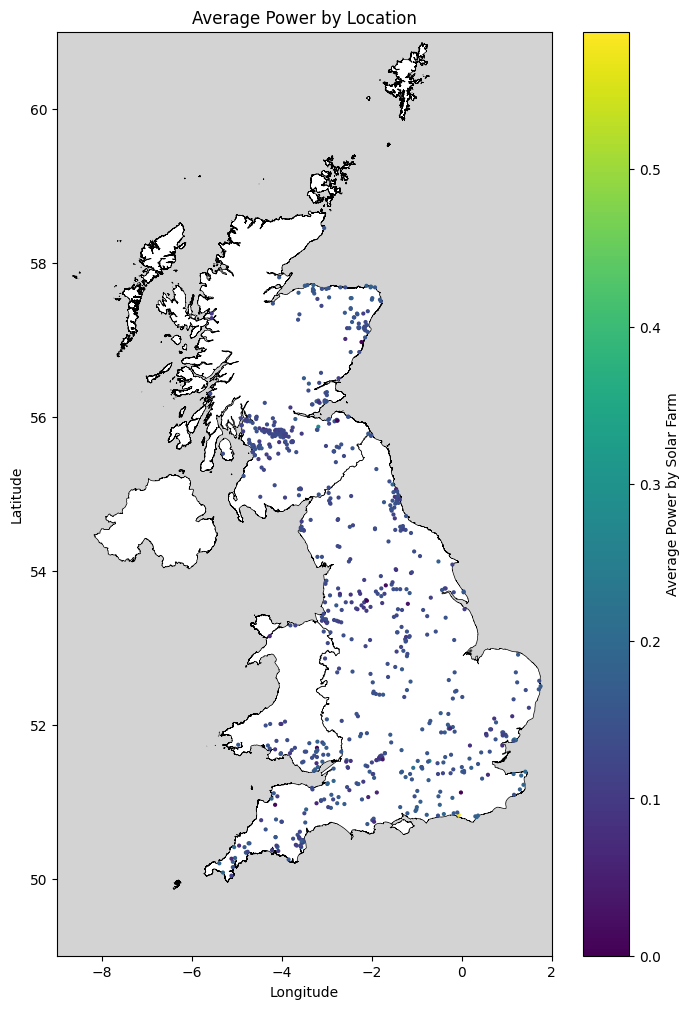

In [5]:
gdf = gpd.GeoDataFrame(
    pv_shared, geometry=gpd.points_from_xy(pv_shared.longitude_rounded, pv_shared.latitude_rounded)
)
gdf = gdf.set_crs("EPSG:4326")
uk_shp = r"C:\Users\james\OneDrive - University of Bristol\Desktop\UCL\aml\data\uk_shape"
uk = gpd.read_file(uk_shp)
uk = uk.to_crs(gdf.crs)

fig, ax = plt.subplots(1, 1, figsize=(8, 12))
ax.set_facecolor('lightgrey')

uk.plot(ax=ax, color='white', edgecolor='black', linewidth=0.5)

gdf.plot(ax=ax, column='avg_power', cmap='viridis', markersize=4, legend=True, legend_kwds={'label': 'Average Power by Solar Farm', 'orientation': "vertical"})

ax.set_xlim([-9, 2])
ax.set_ylim([49, 61])

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Average Power by Location')

plt.show()

In [ ]:
gdf = gpd.GeoDataFrame(
    pv_shared, geometry=gpd.points_from_xy(pv_shared.longitude_rounded, pv_shared.latitude_rounded)
)
gdf = gdf.set_crs("EPSG:4326")
uk_shp = r"C:\Users\james\OneDrive - University of Bristol\Desktop\UCL\aml\data\uk_shape"
uk = gpd.read_file(uk_shp)
uk = uk.to_crs(gdf.crs)

fig, ax = plt.subplots(1, 1, figsize=(8, 12))
ax.set_facecolor('lightgrey')

uk.plot(ax=ax, color='white', edgecolor='black', linewidth=0.5)

gdf.plot(ax=ax, column='generation_wh_avg', cmap='viridis', markersize=4, legend=True, legend_kwds={'label': 'Average Power by Solar Farm', 'orientation': "vertical"})

ax.set_xlim([-9, 2])
ax.set_ylim([49, 61])

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Average Daily Wh by Location')

plt.show()

In [7]:
#!pip install geopy

     -------------------------------------- 125.4/125.4 kB 2.5 MB/s eta 0:00:00
     ---------------------------------------- 40.3/40.3 kB ? eta 0:00:00


In [14]:
import geopandas as gpd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from geopy.distance import geodesic
from scipy import stats


In [13]:
def calculate_average_nearest_neighbor_distance(gdf):
    coords = np.array(list(zip(gdf.geometry.y, gdf.geometry.x)))
    
    nbrs = NearestNeighbors(n_neighbors=2, metric='haversine').fit(np.radians(coords))
    
    distances, indices = nbrs.kneighbors(np.radians(coords))
    
    distances_in_km = distances[:, 1] * 6371
    
    return np.mean(distances_in_km)

# Compute the average distance to the closest neighbor
average_distance = calculate_average_nearest_neighbor_distance(gdf)
print(f"Mean average distance to the solar farms closest neighbor: {average_distance:.2f} km")

Mean average distance to the solar farms closest neighbor: 6.01 km


## For generating the angle of solar incidence  

In [4]:
#this block finds the long and lat for the sites where it is available 
pv_ss_id = pv.index.get_level_values("ss_id").unique()
pv_ss_time = pv.index.get_level_values("timestamp")
pv_meta = pd.read_csv("data/pv/metadata.csv")
pv_meta_ssid = pv_meta.ss_id
shared_id = [x for x in pv_ss_id if x in pv_meta_ssid]
pv_shared = pv_meta[pv_meta["ss_id"].isin(shared_id)] #shared location data, only 698 of 908 sites in the pv file have long and lat for plotting


In [5]:
#Merges 
pv_shared_merge = pv_shared[["ss_id", "latitude_rounded", "longitude_rounded", "orientation", "tilt"]]
pv_reset = pv.reset_index()

pv_az = pd.merge(pv_reset, pv_shared_merge[['ss_id', 'latitude_rounded', 'longitude_rounded', "orientation", "tilt"]], on='ss_id', how='left').dropna().set_index(["timestamp", "ss_id"])
pv_az["altitude"] = 0
pv_az_pre = pv_az.reset_index()
pv_az_pre

,timestamp,ss_id,power,latitude_rounded,longitude_rounded,orientation,tilt,altitude
0,2020-07-01 00:00:00+00:00,2607,0.0,52.44,-0.12,200.0,35.0,0
1,2020-07-01 00:00:00+00:00,2626,0.0,54.99,-3.18,270.0,22.0,0
2,2020-07-01 00:00:00+00:00,2631,0.0,51.81,-2.50,130.0,30.0,0
3,2020-07-01 00:00:00+00:00,2657,0.0,51.49,0.36,185.0,47.0,0
4,2020-07-01 00:00:00+00:00,2729,0.0,51.61,-0.24,180.0,45.0,0
...,...,...,...,...,...,...,...,...
6039341,2020-07-31 23:55:00+00:00,18873,0.0,53.59,-3.04,290.0,35.0,0
6039342,2020-07-31 23:55:00+00:00,18989,0.0,53.55,-2.23,207.0,35.0,0
6039343,2020-07-31 23:55:00+00:00,18990,0.0,53.76,-1.52,180.0,34.0,0
6039344,2020-07-31 23:55:00+00:00,22335,0.0,53.10,-2.04,140.0,21.0,0


In [6]:
#Calculates the azimuth
tz = 'Europe/London'
location_data = {
    'latitude': pv_az_pre['latitude_rounded'].mean(),  # Using mean latitude and longitude
    'longitude': pv_az_pre['longitude_rounded'].mean(),
    'altitude': pv_az_pre['altitude'].mean()  # You may want to adjust how you handle altitude
}

# Convert timestamps from UTC to the UK timezone and sort
pv_az_pre['timestamp'] = pd.to_datetime(pv_az_pre['timestamp'], utc=True).dt.tz_convert(tz)

# Create a single location object
location = pvlib.location.Location(location_data['latitude'], location_data['longitude'], tz, location_data['altitude'])

# Calculate solar position for all times at once
solar_position = location.get_solarposition(pv_az_pre['timestamp'])

# Assign the azimuth values directly
pv_az_pre['solar_azimuth'] = solar_position['azimuth'].values
pv_az_pre['solar_azimuth_south'] = (pv_az_pre['solar_azimuth'] - 180) % 360





#Calculates the solar zenith and then converts required values to radians
tz = 'Europe/London'
location_data = {
    'latitude': pv_az_pre['latitude_rounded'].mean(),
    'longitude': pv_az_pre['longitude_rounded'].mean(),
    'altitude': pv_az_pre['altitude'].mean()
}

# Convert timestamps from UTC to the UK timezone and sort
pv_az_pre['timestamp'] = pd.to_datetime(pv_az_pre['timestamp'], utc=True).dt.tz_convert(tz)

# Create a single location object
location = pvlib.location.Location(
    location_data['latitude'], 
    location_data['longitude'], 
    tz, 
    location_data['altitude']
)
solar_position = location.get_solarposition(pv_az_pre['timestamp'])
pv_az_pre['solar_zenith'] = 90 - solar_position['elevation'].values


pv_az_pre['solar_azimuth_radians'] = np.radians(pv_az_pre['solar_azimuth'])
pv_az_pre['solar_azimuth_south_radians'] = np.radians(pv_az_pre['solar_azimuth_south'])

pv_az_pre['solar_zenith_radians'] = np.radians(pv_az_pre['solar_zenith'])
pv_az_pre["tilt_radians"] = np.radians(pv_az_pre['tilt'])
pv_az_pre["latitude_rounded_radians"] = np.radians(pv_az_pre['latitude_rounded'])
pv_az_pre["longitude_rounded_radians"] = np.radians(pv_az_pre['longitude_rounded'])
pv_az_pre["orientation_radians"] = np.radians(pv_az_pre['orientation'])

pv_az_pre['timestamp'] = pv_az_pre['timestamp'].dt.tz_convert('UTC')

In [7]:
cos_theta_inc = (
    np.sin(pv_az_pre['latitude_rounded_radians']) * np.cos(pv_az_pre['solar_zenith_radians']) * np.cos(pv_az_pre['tilt_radians']) +
    np.sin(pv_az_pre['solar_zenith_radians']) * np.cos(pv_az_pre['latitude_rounded_radians']) * np.sin(pv_az_pre['tilt_radians']) * np.cos(pv_az_pre['orientation_radians'] - pv_az_pre['solar_azimuth_south_radians']) +
    np.cos(pv_az_pre['solar_zenith_radians']) * np.sin(pv_az_pre['tilt_radians']) * np.sin(pv_az_pre['orientation_radians'] - pv_az_pre['solar_azimuth_south_radians'])
)
cos_theta_inc = np.clip(cos_theta_inc, -1.0, 1.0)

pv_az_pre['angle_of_incidence_radians'] = np.arccos(cos_theta_inc)

In [61]:
pv_inc = pv_az_pre.drop(columns={'latitude_rounded', 'longitude_rounded',
       'orientation', 'tilt', 'altitude', 'solar_azimuth',
       'solar_azimuth_radians', 'solar_zenith', 'solar_zenith_radians',
       'tilt_radians', 'latitude_rounded_radians', 'longitude_rounded_radians',
       'orientation_radians', "solar_azimuth_south", "solar_azimuth_south_radians"}).sort_values([ "timestamp"]).set_index(["timestamp", "ss_id"])

In [32]:
pv_inc_chk = pv_inc.reset_index()

In [66]:
df = pv_inc.reset_index()
df["timestamp"] = pd.to_datetime(df["timestamp"])
pv_inc = df.set_index(["timestamp", "ss_id"])

#check the utc is not causing a mis calculation 

In [ ]:
#Convert to raidians after and the calculate the solar irraidiance 

In [74]:
inc_id = list(pv_inc.index.get_level_values(1).unique())
pv_id = list(pv.index.get_level_values(1).unique())

## Here in these are used for running the model

In [111]:
#This function extracts the area around each individual site using the PV dicts pixel based (as in the location of sites are determined by their pixel in the image) location and then extracts an area around each site. These areas are combined, based on their timestamp,
#with the HRV data that then has its satellite imagery data extracted. This implies that the model is using subsets of the satellite imagery to train the model to make predictions for each site rather than using the whole image and then "learning" where the sites are.

class ChallengeDataset(IterableDataset):#This function sets up the data so that it can be iterated through by the CNN
    def __init__(self, pv, hrv, site_locations, sites=None):#The "self" augmentation here is used to use create a shared class between the different data types that are then iterable based on their shared timestamp
        self.pv = pv
        self.hrv = hrv
        self._site_locations = site_locations
        self._sites = sites if sites else list(site_locations["hrv"].keys())#This gets the individual site ids which are stored as the dict's keys

    def _get_image_times(self):#This function starts at the minimum date in the set and iterates up to the highest date, this is done as the data set is large and due to the nature of the parquette and xarray
        min_date = datetime(2020, 7, 1)
        max_date = datetime(2020, 7, 2)
        #max and min need to be changed if we use more than one month of data
        start_time = time(8)
        end_time = time(17)

        date = min_date#starts at the first timestamp
        while date <= max_date: #iterates through up to the max
            current_time = datetime.combine(date, start_time)
            while current_time.time() < end_time:
                if current_time:
                    yield current_time

                current_time += timedelta(minutes=60)

            date += timedelta(days=1)

    def __iter__(self):
        for time in self._get_image_times():
            first_hour = slice(str(time), str(time + timedelta(minutes=55)))#gets the time and then uses this to select the corresponding time from the pv set  

            pv_features = pv.xs(first_hour, drop_level=False)  # this gets the pv yield of the current timestamp selected earlier
            pv_targets = pv.xs(
                slice(  # type: ignore
                    str(time + timedelta(hours=1)),
                    str(time + timedelta(hours=4, minutes=55)),
                ),
                drop_level=False,
            )#pv targets defines the time span over which we are trying to make pv yield predictions
            #print( pv_features)
            #print(pv_features)

            hrv_data = self.hrv["data"].sel(time=first_hour).to_numpy()#gets the hrv satellite image that is associated with the first hour timestamp setting it up as an input feature

            for site in self._sites:
                try:
                    # Get solar PV features and targets, the site_targets is used to find the models loss
                    site_features = pv_features.xs(site, level=1).to_numpy().squeeze(-1)#gets the pixel based location of the pv site and then uses this to make predictions based on the individual sites
                    site_targets = pv_targets.xs(site, level=1).to_numpy().squeeze(-1)
                    assert site_features.shape == (12,) and site_targets.shape == (48,)#compresses the data from N dimensions to 12 and 48 respectively
                    print(site)
                    #print(site)
                    # Get a 128x128 HRV crop centred on the site over the previous hour
                    x, y = self._site_locations["hrv"][site]#gets the location of the site based on the pv sites pixel level location
                    hrv_features = hrv_data[:, y - 64 : y + 64, x - 64 : x + 64, 0]
                    assert hrv_features.shape == (12, 128, 128)#crops the image to be be 128x128 around the site
                    #asset is used to force the dimensions of the extracted site level image to be the same
                    # How might you adapt this for the non-HRV, weather and aerosol data?
                except:
                    continue

                yield site_features, hrv_features, site_targets

In [112]:
dataset = ChallengeDataset( pv, hrv, site_locations)

# Iterate over the dataset and break after the first iteration to print the pv_features
for pv_features, hrv_features, site_targets in dataset:
    # Assuming you want to print the pv_features for the first site
    print("PV Features for the first site:")
    print(pv_features)
    break 

2607
PV Features for the first site:
[0.24236082 0.25453959 0.18922122 0.16577837 0.20899755 0.22073959
 0.24724816 0.22385347 0.21168286 0.32554163 0.30427714 0.21674857]


## 6 x 6 crop four hours

In [15]:
#This function extracts the area around each individual site using the PV dicts pixel based (as in the location of sites are determined by their pixel in the image) location and then extracts an area around each site. These areas are combined, based on their timestamp,
#with the HRV data that then has its satellite imagery data extracted. This implies that the model is using subsets of the satellite imagery to train the model to make predictions for each site rather than using the whole image and then "learning" where the sites are.

class ChallengeDataset_crop(IterableDataset):#This function sets up the data so that it can be iterated through by the CNN
    def __init__(self, pv, hrv, site_locations, sites=None):#The "self" augmentation here is used to use create a shared class between the different data types that are then iterable based on their shared timestamp
        self.pv = pv
        self.hrv = hrv
        self._site_locations = site_locations
        self._sites = sites if sites else list(site_locations["hrv"].keys())#This gets the individual site ids which are stored as the dict's keys

    def _get_image_times(self):#This function starts at the minimum date in the set and iterates up to the highest date, this is done as the data set is large and due to the nature of the parquette and xarray
        min_date = datetime(2020, 7, 1)
        max_date = datetime(2020, 7, 31)
        #max and min need to be changed if we use more than one month of data
        start_time = time(8)
        end_time = time(17)

        date = min_date#starts at the first timestamp
        while date <= max_date: #iterates through up to the max
            current_time = datetime.combine(date, start_time)
            while current_time.time() < end_time:
                if current_time:
                    yield current_time

                current_time += timedelta(minutes=60)

            date += timedelta(days=1)

    def __iter__(self):
        for time in self._get_image_times():
            first_hour = slice(str(time), str(time + timedelta(minutes=55)))#gets the time and then uses this to select the corresponding time from the pv set  

            pv_features = pv.xs(first_hour, drop_level=False)  # this gets the pv yield of the current timestamp selected earlier
            pv_targets = pv.xs(
                slice(  # type: ignore
                    str(time + timedelta(hours=1)),
                    str(time + timedelta(hours=4, minutes=55)),
                ),
                drop_level=False,
            )#pv targets defines the time span over which we are trying to make pv yield predictions
            #print( pv_features)
            #print(pv_features)

            hrv_data = self.hrv["data"].sel(time=first_hour).to_numpy()#gets the hrv satellite image that is associated with the first hour timestamp setting it up as an input feature

            for site in self._sites:
                try:
                    # Get solar PV features and targets, the site_targets is used to find the models loss
                    site_features = pv_features.xs(site, level=1).to_numpy().squeeze(-1)#gets the pixel based location of the pv site and then uses this to make predictions based on the individual sites
                    site_targets = pv_targets.xs(site, level=1).to_numpy().squeeze(-1)
                    assert site_features.shape == (12,) and site_targets.shape == (48,)#compresses the data from N dimensions to 12 and 48 respectively
                    
                    #print(site)
                    # Get a 128x128 HRV crop centred on the site over the previous hour
                    x, y = self._site_locations["hrv"][site]#gets the location of the site based on the pv sites pixel level location
                    hrv_features = hrv_data[:, y - 3 : y + 3, x - 3 : x + 3, 0]
                    assert hrv_features.shape == (12, 6, 6)#crops the image to be be 128x128 around the site
                    #asset is used to force the dimensions of the extracted site level image to be the same
                    # How might you adapt this for the non-HRV, weather and aerosol data?
                except:
                    continue

                yield site_features, hrv_features, site_targets

## 6 x 6 One hour

In [4]:
#This function extracts the area around each individual site using the PV dicts pixel based (as in the location of sites are determined by their pixel in the image) location and then extracts an area around each site. These areas are combined, based on their timestamp,
#with the HRV data that then has its satellite imagery data extracted. This implies that the model is using subsets of the satellite imagery to train the model to make predictions for each site rather than using the whole image and then "learning" where the sites are.

class ChallengeDataset_crop_onehour(IterableDataset):#This function sets up the data so that it can be iterated through by the CNN
    def __init__(self, pv, hrv, site_locations, sites=None):#The "self" augmentation here is used to use create a shared class between the different data types that are then iterable based on their shared timestamp
        self.pv = pv
        self.hrv = hrv
        self._site_locations = site_locations
        self._sites = sites if sites else list(site_locations["hrv"].keys())#This gets the individual site ids which are stored as the dict's keys

    def _get_image_times(self):#This function starts at the minimum date in the set and iterates up to the highest date, this is done as the data set is large and due to the nature of the parquette and xarray
        min_date = datetime(2020, 7, 1)
        max_date = datetime(2020, 7, 31)
        #max and min need to be changed if we use more than one month of data
        start_time = time(8)
        end_time = time(17)

        date = min_date#starts at the first timestamp
        while date <= max_date: #iterates through up to the max
            current_time = datetime.combine(date, start_time)
            while current_time.time() < end_time:
                if current_time:
                    yield current_time

                current_time += timedelta(minutes=60)

            date += timedelta(days=1)

    def __iter__(self):
        for time in self._get_image_times():
            first_hour = slice(str(time), str(time + timedelta(minutes=55)))#gets the time and then uses this to select the corresponding time from the pv set  

            pv_features = pv.xs(first_hour, drop_level=False)  # this gets the pv yield of the current timestamp selected earlier
            pv_targets = pv.xs(
                slice(  # type: ignore
                    str(time + timedelta(hours=1)),
                    str(time + timedelta(hours=1, minutes=55)),
                ),
                drop_level=False,
            )#pv targets defines the time span over which we are trying to make pv yield predictions
            #print( pv_features)
            #print(pv_features)

            hrv_data = self.hrv["data"].sel(time=first_hour).to_numpy()#gets the hrv satellite image that is associated with the first hour timestamp setting it up as an input feature

            for site in self._sites:
                try:
                    # Get solar PV features and targets, the site_targets is used to find the models loss
                    site_features = pv_features.xs(site, level=1).to_numpy().squeeze(-1)#gets the pixel based location of the pv site and then uses this to make predictions based on the individual sites
                    site_targets = pv_targets.xs(site, level=1).to_numpy().squeeze(-1)
                    assert site_features.shape == (12,) and site_targets.shape == (12,)#compresses the data from N dimensions to 12 and 48 respectively
                    
                    #print(site)
                    # Get a 128x128 HRV crop centred on the site over the previous hour
                    x, y = self._site_locations["hrv"][site]#gets the location of the site based on the pv sites pixel level location
                    hrv_features = hrv_data[:, y - 3 : y + 3, x - 3 : x + 3, 0]
                    assert hrv_features.shape == (12, 6, 6)#crops the image to be be 128x128 around the site
                    #asset is used to force the dimensions of the extracted site level image to be the same
                    # How might you adapt this for the non-HRV, weather and aerosol data?
                except:
                    continue

                yield site_features, hrv_features, site_targets

In [193]:
#This function extracts the area around each individual site using the PV dicts pixel based (as in the location of sites are determined by their pixel in the image) location and then extracts an area around each site. These areas are combined, based on their timestamp,
#with the HRV data that then has its satellite imagery data extracted. This implies that the model is using subsets of the satellite imagery to train the model to make predictions for each site rather than using the whole image and then "learning" where the sites are.

class ChallengeDataset_inc(IterableDataset):#This function sets up the data so that it can be iterated through by the CNN
    def __init__(self,  pv_inc, hrv, site_locations, sites=None):#The "self" augmentation here is used to use create a shared class between the different data types that are then iterable based on their shared timestamp
        #self.pv = pv
        self.pv_inc = pv_inc
        self.hrv = hrv
        self._site_locations = site_locations
        self._sites = sites if sites else list(site_locations["hrv"].keys())#This gets the individual site ids which are stored as the dict's keys

    def _get_image_times(self):#This function starts at the minimum date in the set and iterates up to the highest date, this is done as the data set is large and due to the nature of the parquette and xarray
        min_date = datetime(2020, 7, 1)
        max_date = datetime(2020, 7, 2)
        #max and min need to be changed if we use more than one month of data
        start_time = time(8)
        end_time = time(17)

        date = min_date#starts at the first timestamp
        while date <= max_date: #iterates through up to the max
            current_time = datetime.combine(date, start_time)
            while current_time.time() < end_time:
                if current_time:
                    yield current_time

                current_time += timedelta(minutes=60)

            date += timedelta(days=1)

    def __iter__(self):
        for time in self._get_image_times():
            first_hour = slice(str(time), str(time + timedelta(minutes=55)))#gets the time and then uses this to select the corresponding time from the pv set  
            #print("Available columns in pv_inc:", self.pv_inc.columns)
           
            pv_features = self.pv_inc.xs(first_hour, drop_level=False)[["power", "angle_of_incidence_radians"]]

        # Fetching PV targets for the future time span
            pv_targets = self.pv_inc.xs(
                slice(
                    str(time + timedelta(hours=1)),  # Start 1 hour after the first_hour
                    str(time + timedelta(hours=4, minutes=55)),  # Up to almost 5 hours later
                ),
                drop_level=False,
            )["power"]
            #print("First hour slice:", first_hour)
            #print("Sample data from pv_inc:", self.pv_inc.xs(first_hour, drop_level=False).head())
            #gets the hrv satellite image that is associated with the first hour timestamp setting it up as an input feature
            hrv_data = self.hrv['data'].sel(time=first_hour).to_numpy()

            for site in self._sites:
                try:
                    #print(site)
                    # Get solar PV features and targets, the site_targets is used to find the models loss
                    site_features = pv_features.xs(site, level=1).to_numpy()#.squeeze(-1)#gets the pixel based location of the pv site and then uses this to make predictions based on the individual sites
                    
                    site_targets = pv_targets.xs(site, level=1).to_numpy()#.squeeze(-1)
                    assert site_features.shape == (12,2) and site_targets.shape == (48,)#compresses the data from N dimensions to 12 and 48 respectively
                  
                    # Get a 128x128 HRV crop centred on the site over the previous hour
                    x, y = self._site_locations["hrv"][site]#gets the location of the site based on the pv sites pixel level location
                    hrv_features = hrv_data[:, y - 64 : y + 64, x - 64 : x + 64, 0]
                    assert hrv_features.shape == (12, 128, 128)#crops the image to be be 128x128 around the site
                    #asset is used to force the dimensions of the extracted site level image to be the same
                    # How might you adapt this for the non-HRV, weather and aerosol data?
                except:
                    continue

                yield site_features, hrv_features, site_targets

In [63]:
dataset = ChallengeDataset_crop_onehour( pv, hrv, site_locations)

# Iterate over the dataset and break after the first iteration to print the pv_features
for pv_features, hrv_features, site_features in dataset:
    # Assuming you want to print the pv_features for the first site
    print("PV Features for the first site:")
    print(pv_features.shape)
    break 

(12,)
(12, 6, 6)
PV Features for the first site:
(12,)


Solar angle model

In [130]:
layers = [4, 4, 4, 4] #Change this to change the number of layers that you are using, 

def conv_block(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    #This section creates a sequence of layers that perform the networks convolution which are applied iteratively in the Resnet_light block
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding), #Feature extraction
        nn.BatchNorm2d(out_channels), #Noramlises the outputs from the convolution layers
        nn.ReLU(inplace=True)#Applies the activation function
    )

class BasicBlock(nn.Module):
    expansion = 1 
    #Applies the convolution established in the previous layer twice giving the F(x) portion of the resnet model
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv_block(in_channels, out_channels, stride=stride)
        self.conv2 = conv_block(out_channels, out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x): #Keeps the x portion of the resnet 
        identity = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample is not None: #Downsamples the model if needed to match the dimensions of outputs if the identity output does not match the F(x) portion of the output
            identity = self.downsample(x)
        out = out + identity #Creates the F(x) + x that is then passed to the relu activation function between the resnet conv layers
        return F.relu(out, inplace=False)  #Relu applied to combined results, 

class ResNet_light_inc(nn.Module):
    #This class stacks the multiple basic blocks set up in the previous functions
    def __init__(self, block, layers):
        #I Think we can reduce the number of layers here as the model is applied four convolutions to generate F(x), the resnet paper uses two.
        super(ResNet_light_inc, self).__init__()
        self.in_channels = 12 #reduce the stride
        self.initial = conv_block(12, 12, kernel_size=2, stride=1, padding=3)#Applies the initial convolution 
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)#Runs maxpool convolution
        self.layer1 = self._make_layer(block, 12, layers[0])
        self.layer2 = self._make_layer(block, 24, layers[1], stride=1)
        self.layer3 = self._make_layer(block, 48, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 96, layers[3], stride=1)
        self.avgpool = nn.AdaptiveMaxPool2d((1, 1))#Forces the consistency of output sizes to be 1x1 
        # Adjust this linear layer based on the concatenated size of HRV and PV features
        self.fc = nn.Linear(96  + 12, 48)  #takes the flatterened output of the conv layers for the 12 hourly time instances and then hands them to 48 different class outputs

    def _make_layer(self, block, out_channels, num_blocks, stride=1):#Used to stack the multiple layers of the resnet model
        downsample = None#This checks to make sure that the stride applied matches between input tensor and the output tensor, I am not completely sure if this changes the dimensions of the output tensor
        if stride != 1 or self.in_channels != out_channels * block.expansion:#Expands the number of outputs compared to the inputs, for the BasicBlock typically no expansion is needed. This is still needed for the model to run. 
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )
        layers = [block(self.in_channels, out_channels, stride, downsample)]#This section creates a series of blocks for the layer
        self.in_channels = out_channels * block.expansion #Ensures that after the blocks have been defined the next layer gets the correct number of input channels
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))#
        return nn.Sequential(*layers)#Stretches the dims of the resnet to match the layers defined above
        #Need to clarify exactly what expansion is doing.
    def forward(self, pv_inc, hrv ):#Defines how the model passes the outputs through the network
        #print("Initial HRV shape:", hrv.shape)  
        #print("Initial PV shape:", pv.shape) 
        #print(f"{pv[0]}")
        x = self.initial(hrv)#Passes the HRV data through the initial block defined earlier
        x = self.maxpool(x)#Downsamples using maxpooling
        #print("Shape after initial conv and maxpool:", x.shape)

        x = self.layer1(x)#Applies the layers defined above, 
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        #print("Shape after ResNet_light blocks:", x.shape)

        x = self.avgpool(x)
        #print("Shape after avgpool:", x.shape)
        x = torch.flatten(x, 1)# Applies the flattering to the second dimension as the first dimension is the batch size
        pv_inc = torch.flatten(pv_inc, start_dim=1)#Flattens the pv data so that the dimensions of the pv tensor match the dimensions of the HRV tensor
        #print(f"Sshape of x = {x.shape} shape of pv = {pv.shape}")
        #x = torch.concat((x, pv), dim=-1)
        #print("Shape after avgpool and flatten:", x.shape)

        
        
        #pv = pv.view(pv.size(0), -1)
        #Checks to make sure that the pv tensor dimensions match the HRV tensor dimensions
        if pv.dim() > 2:
            pv = torch.flatten(pv_inc, start_dim=1)
        #print("Adjusted PV shape:", pv.shape)

        combined = torch.cat((x, pv_inc), dim=1)#Combines the pv and hrv data along the feature dimension

        if self.fc.in_features != combined.shape[1]:
            self.fc = nn.Linear(combined.shape[1], 48).to(combined.device)
            #Above runs a check to make sure that the number of input features is correct
        out = self.fc(combined) #takes the combined output of the pv and hrv and passes them to the fully connected layer defined above
        return out
model_light_res_inc = ResNet_light_inc(BasicBlock, layers).to(device)


In [137]:
def conv_block(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv_block(in_channels, out_channels, stride=stride)
        self.conv2 = conv_block(out_channels, out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out = out + identity
        return F.relu(out, inplace=False)

class ResNet_light_inc(nn.Module):

    def __init__(self, block, layers):
        super(ResNet_light_inc, self).__init__()
        self.in_channels = 12
        self.initial = conv_block(12, 12, kernel_size=2, stride=1, padding=3)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 12, layers[0])
        self.layer2 = self._make_layer(block, 24, layers[1], stride=1)
        self.layer3 = self._make_layer(block, 48, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 96, layers[3], stride=1)
        self.avgpool = nn.AdaptiveMaxPool2d((1, 1))
        self.fc = nn.Linear(96 + 24, 48)#Might need to adjust the 24 for the amount of features trained on

    def _make_layer(self, block, out_channels, num_blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )
        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels * block.expansion
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, pv_inc, hrv):
        x = self.initial(hrv)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        pv_inc = torch.flatten(pv_inc, start_dim=1)
        if pv_inc.dim() > 2:
            pv_inc = torch.flatten(pv_inc, start_dim=1)
        combined = torch.cat((x, pv_inc), dim=1)
        #This line might increase computational intensity
        if self.fc.in_features != combined.shape[1]:
            self.fc = nn.Linear(combined.shape[1], 48).to(combined.device)
        out = self.fc(combined)
        return out

model_light_res_inc = ResNet_light_inc(BasicBlock, layers).to(device)

In [138]:
hrv_input_size = (1, 12, 224, 224)  # For example: batch size of 1, 12 channels, 224x224 height and width
pv_input_size = (1, 1, 224, 224)    # For example: batch size of 1, 1 channel, 224x224 height and width

# You need to provide the sizes in a list if your model expects multiple inputs
model_input_sizes = [hrv_input_size, pv_input_size]

# Use torchinfo's summary function
# The input size is passed as a list of tuples, each corresponding to the size of an input the model expects
summary(model_light_res_inc, input_size=[(1, 12), (1, 12, 128, 128)])

Layer (type:depth-idx)                   Output Shape              Param #
ResNet_light_inc                         [1, 48]                   5,808
├─Sequential: 1-1                        [1, 12, 133, 133]         --
│    └─Conv2d: 2-1                       [1, 12, 133, 133]         588
│    └─BatchNorm2d: 2-2                  [1, 12, 133, 133]         24
│    └─ReLU: 2-3                         [1, 12, 133, 133]         --
├─MaxPool2d: 1-2                         [1, 12, 67, 67]           --
├─Sequential: 1-3                        [1, 12, 67, 67]           --
│    └─BasicBlock: 2-4                   [1, 12, 67, 67]           --
│    │    └─Sequential: 3-1              [1, 12, 67, 67]           1,332
│    │    └─Sequential: 3-2              [1, 12, 67, 67]           1,332
│    └─BasicBlock: 2-5                   [1, 12, 67, 67]           --
│    │    └─Sequential: 3-3              [1, 12, 67, 67]           1,332
│    │    └─Sequential: 3-4              [1, 12, 67, 67]           1,332

Deeper light weight resnet, good performance over a day and trains quickly.

In [21]:
layers = [4, 4, 4, 4] #For a deeper resnet with 16 total conv layers

def conv_block(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv_block(in_channels, out_channels, stride=stride)
        self.conv2 = conv_block(out_channels, out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out = out + identity
        return F.relu(out, inplace=False)

class ResNet_light_deep(nn.Module):
    
    def __init__(self, block, layers):
        
        super(ResNet_light_deep, self).__init__()
        self.in_channels = 12 #reduce the stride
        self.initial = conv_block(12, 12, kernel_size=2, stride=1, padding=3)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 12, layers[0])
        self.layer2 = self._make_layer(block, 24, layers[1], stride=1)
        self.layer3 = self._make_layer(block, 48, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 96, layers[3], stride=1)
        self.avgpool = nn.AdaptiveMaxPool2d((1, 1))
        # Adjust this linear layer based on the concatenated size of HRV and PV features
        self.fc = nn.Linear(96  + 12, 48)  

    def _make_layer(self, block, out_channels, num_blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )
        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels * block.expansion
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, pv, hrv ):
        #print("Initial HRV shape:", hrv.shape)  
        #print("Initial PV shape:", pv.shape) 
        #print(f"{pv[0]}")
        x = self.initial(hrv)
        x = self.maxpool(x)
        #print("Shape after initial conv and maxpool:", x.shape)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        #print("Shape after ResNet_light blocks:", x.shape)

        x = self.avgpool(x)
        #print("Shape after avgpool:", x.shape)
        x = torch.flatten(x, 1)
        pv = torch.flatten(pv, start_dim=1)
        #print(f"Sshape of x = {x.shape} shape of pv = {pv.shape}")
        #x = torch.concat((x, pv), dim=-1)
        #print("Shape after avgpool and flatten:", x.shape)

        
        
        #pv = pv.view(pv.size(0), -1)
        if pv.dim() > 2:
            pv = torch.flatten(pv, start_dim=1)
        #print("Adjusted PV shape:", pv.shape)

        combined = torch.cat((x, pv), dim=1)

        if self.fc.in_features != combined.shape[1]:
            self.fc = nn.Linear(combined.shape[1], 48).to(combined.device)

        out = self.fc(combined)
        return out
model_light_deep_res = ResNet_light_deep(BasicBlock, layers).to(device)


Deeper light weight resnet using the 6 x 6 images

In [20]:
layers = [4, 4, 4, 4] #For a deeper resnet with 16 total conv layers

def conv_block(in_channels, out_channels, kernel_size=1, stride=1, padding=0):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv_block(in_channels, out_channels, stride=stride)
        self.conv2 = conv_block(out_channels, out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out = out + identity
        return F.relu(out, inplace=False)

class ResNet_light_deep_crop(nn.Module):
    
    def __init__(self, block, layers):
        
        super(ResNet_light_deep_crop, self).__init__()
        self.in_channels = 12 #reduce the stride
        self.initial = conv_block(12, 12, kernel_size=1, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(kernel_size=1, stride=1, padding=0)
        self.layer1 = self._make_layer(block, 12, layers[0])
        self.layer2 = self._make_layer(block, 24, layers[1], stride=1)
        self.layer3 = self._make_layer(block, 48, layers[2], stride=1)
        self.layer4 = self._make_layer(block, 96, layers[3], stride=1)
        self.avgpool = nn.AdaptiveMaxPool2d((1, 1))
        # Adjust this linear layer based on the concatenated size of HRV and PV features
        self.fc = nn.Linear(96  + 12, 48)  

    def _make_layer(self, block, out_channels, num_blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )
        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels * block.expansion
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, pv, hrv ):
        #print("Initial HRV shape:", hrv.shape)  
        #print("Initial PV shape:", pv.shape) 
        #print(f"{pv[0]}")
        x = self.initial(hrv)
        x = self.maxpool(x)
        #print("Shape after initial conv and maxpool:", x.shape)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        #print("Shape after ResNet_light blocks:", x.shape)

        x = self.avgpool(x)
        #print("Shape after avgpool:", x.shape)
        x = torch.flatten(x, 1)
        pv = torch.flatten(pv, start_dim=1)
        #print(f"Sshape of x = {x.shape} shape of pv = {pv.shape}")
        #x = torch.concat((x, pv), dim=-1)
        #print("Shape after avgpool and flatten:", x.shape)

        
        
        #pv = pv.view(pv.size(0), -1)
        if pv.dim() > 2:
            pv = torch.flatten(pv, start_dim=1)
        #print("Adjusted PV shape:", pv.shape)

        combined = torch.cat((x, pv), dim=1)

        if self.fc.in_features != combined.shape[1]:
            self.fc = nn.Linear(combined.shape[1], 48).to(combined.device)

        out = self.fc(combined)
        return out
model_light_deep_res_crop = ResNet_light_deep_crop(BasicBlock, layers).to(device)


In [26]:
hrv_input_size = (1, 12, 224, 224)  # For example: batch size of 1, 12 channels, 224x224 height and width
pv_input_size = (1, 1, 224, 224)    # For example: batch size of 1, 1 channel, 224x224 height and width

# You need to provide the sizes in a list if your model expects multiple inputs
model_input_sizes = [hrv_input_size, pv_input_size]

# Use torchinfo's summary function
# The input size is passed as a list of tuples, each corresponding to the size of an input the model expects
summary(model_light_deep_res_crop, input_size=[(1, 12), (1, 12, 6, 6)])

Layer (type:depth-idx)                   Output Shape              Param #
ResNet_light_deep_crop                   [1, 48]                   --
├─Sequential: 1-1                        [1, 12, 6, 6]             --
│    └─Conv2d: 2-1                       [1, 12, 6, 6]             156
│    └─BatchNorm2d: 2-2                  [1, 12, 6, 6]             24
│    └─ReLU: 2-3                         [1, 12, 6, 6]             --
├─MaxPool2d: 1-2                         [1, 12, 6, 6]             --
├─Sequential: 1-3                        [1, 12, 6, 6]             --
│    └─BasicBlock: 2-4                   [1, 12, 6, 6]             --
│    │    └─Sequential: 3-1              [1, 12, 6, 6]             180
│    │    └─Sequential: 3-2              [1, 12, 6, 6]             180
│    └─BasicBlock: 2-5                   [1, 12, 6, 6]             --
│    │    └─Sequential: 3-3              [1, 12, 6, 6]             180
│    │    └─Sequential: 3-4              [1, 12, 6, 6]             180
│    └─Bas

Deeper light weight resnet using the 6 x 6 images and one hour forecasts

In [9]:
layers = [4, 4, 4, 4] #For a deeper resnet with 16 total conv layers

def conv_block(in_channels, out_channels, kernel_size=1, stride=1, padding=0):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv_block(in_channels, out_channels, stride=stride)
        self.conv2 = conv_block(out_channels, out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out = out + identity
        return F.relu(out, inplace=False)

class ResNet_light_deep_crop_hour(nn.Module):
    
    def __init__(self, block, layers):
        
        super(ResNet_light_deep_crop_hour, self).__init__()
        self.in_channels = 12 #reduce the stride
        self.initial = conv_block(12, 12, kernel_size=1, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(kernel_size=1, stride=1, padding=0)
        self.layer1 = self._make_layer(block, 12, layers[0])
        self.layer2 = self._make_layer(block, 24, layers[1], stride=1)
        self.layer3 = self._make_layer(block, 48, layers[2], stride=1)
        self.layer4 = self._make_layer(block, 96, layers[3], stride=1)
        self.avgpool = nn.AdaptiveMaxPool2d((1, 1))
        # Adjust this linear layer based on the concatenated size of HRV and PV features
        self.fc = nn.Linear(96  + 12, 12)  

    def _make_layer(self, block, out_channels, num_blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )
        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels * block.expansion
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, pv, hrv ):
        #print("Initial HRV shape:", hrv.shape)  
        #print("Initial PV shape:", pv.shape) 
        #print(f"{pv[0]}")
        x = self.initial(hrv)
        x = self.maxpool(x)
        #print("Shape after initial conv and maxpool:", x.shape)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        #print("Shape after ResNet_light blocks:", x.shape)

        x = self.avgpool(x)
        #print("Shape after avgpool:", x.shape)
        x = torch.flatten(x, 1)
        pv = torch.flatten(pv, start_dim=1)
        #print(f"Sshape of x = {x.shape} shape of pv = {pv.shape}")
        #x = torch.concat((x, pv), dim=-1)
        #print("Shape after avgpool and flatten:", x.shape)

        
        
        #pv = pv.view(pv.size(0), -1)
        if pv.dim() > 2:
            pv = torch.flatten(pv, start_dim=1)
        #print("Adjusted PV shape:", pv.shape)

        combined = torch.cat((x, pv), dim=1)

        if self.fc.in_features != combined.shape[1]:
            self.fc = nn.Linear(combined.shape[1], 12).to(combined.device)

        out = self.fc(combined)
        return out
    
model_light_deep_res_crop_hour = ResNet_light_deep_crop_hour(BasicBlock, layers).to(device)


In [72]:
model_light_deep_res_crop_hour = ResNet_light_deep_crop_hour(BasicBlock, layers)
print(model_light_deep_res_crop_hour)

ResNet_light_deep_crop_hour(
  (initial): Sequential(
    (0): Conv2d(12, 12, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv2d(12, 12, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv2d(12, 12, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv2d(12, 12, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, tra

In [66]:
hrv_input_size = (1, 12, 224, 224)  # For example: batch size of 1, 12 channels, 224x224 height and width
pv_input_size = (1, 1, 224, 224)    # For example: batch size of 1, 1 channel, 224x224 height and width

# You need to provide the sizes in a list if your model expects multiple inputs
model_input_sizes = [hrv_input_size, pv_input_size]

# Use torchinfo's summary function
# The input size is passed as a list of tuples, each corresponding to the size of an input the model expects
summary(model_light_deep_res_crop_hour, input_size=[(1, 12), (1, 12, 6, 6)])

Final output shape: torch.Size([1, 12])


Layer (type:depth-idx)                   Output Shape              Param #
ResNet_light_deep_crop_hour              [1, 12]                   --
├─Sequential: 1-1                        [1, 12, 6, 6]             --
│    └─Conv2d: 2-1                       [1, 12, 6, 6]             156
│    └─BatchNorm2d: 2-2                  [1, 12, 6, 6]             24
│    └─ReLU: 2-3                         [1, 12, 6, 6]             --
├─MaxPool2d: 1-2                         [1, 12, 6, 6]             --
├─Sequential: 1-3                        [1, 12, 6, 6]             --
│    └─BasicBlock: 2-4                   [1, 12, 6, 6]             --
│    │    └─Sequential: 3-1              [1, 12, 6, 6]             180
│    │    └─Sequential: 3-2              [1, 12, 6, 6]             180
│    └─BasicBlock: 2-5                   [1, 12, 6, 6]             --
│    │    └─Sequential: 3-3              [1, 12, 6, 6]             180
│    │    └─Sequential: 3-4              [1, 12, 6, 6]             180
│    └─Bas

In [129]:
#!pip install torchsummary
from torchinfo import summary


Output of the first resnet I made

In [11]:
hrv_input_size = (1, 12, 224, 224)  # For example: batch size of 1, 12 channels, 224x224 height and width
pv_input_size = (1, 1, 224, 224)    # For example: batch size of 1, 1 channel, 224x224 height and width

# You need to provide the sizes in a list if your model expects multiple inputs
model_input_sizes = [hrv_input_size, pv_input_size]

# Use torchinfo's summary function
# The input size is passed as a list of tuples, each corresponding to the size of an input the model expects
summary(model, input_size=[(1, 12), (1, 12, 128, 128)])

Initial HRV shape: torch.Size([1, 12, 128, 128])
Initial PV shape: torch.Size([1, 12])
tensor([0.7790, 0.9008, 0.9214, 0.2327, 0.2230, 0.0516, 0.0247, 0.5559, 0.5794,
        0.3478, 0.3755, 0.3538])
Shape after initial conv and maxpool: torch.Size([1, 64, 64, 64])
Shape after ResNet blocks: torch.Size([1, 512, 64, 64])
Shape after avgpool: torch.Size([1, 512, 1, 1])
Shape after avgpool and flatten: torch.Size([1, 512])
Adjusted PV shape: torch.Size([1, 12])


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 48]                   --
├─Sequential: 1-1                        [1, 64, 128, 128]         --
│    └─Conv2d: 2-1                       [1, 64, 128, 128]         37,696
│    └─BatchNorm2d: 2-2                  [1, 64, 128, 128]         128
│    └─ReLU: 2-3                         [1, 64, 128, 128]         --
├─MaxPool2d: 1-2                         [1, 64, 64, 64]           --
├─Sequential: 1-3                        [1, 64, 64, 64]           --
│    └─BasicBlock: 2-4                   [1, 64, 64, 64]           --
│    │    └─Sequential: 3-1              [1, 64, 64, 64]           37,056
│    │    └─Sequential: 3-2              [1, 64, 64, 64]           37,056
│    └─BasicBlock: 2-5                   [1, 64, 64, 64]           --
│    │    └─Sequential: 3-3              [1, 64, 64, 64]           37,056
│    │    └─Sequential: 3-4              [1, 64, 64, 64]           3

Output for the lighter weight resnet

In [27]:
hrv_input_size = (1, 12, 224, 224)  # For example: batch size of 1, 12 channels, 224x224 height and width
pv_input_size = (1, 1, 224, 224)    # For example: batch size of 1, 1 channel, 224x224 height and width

# You need to provide the sizes in a list if your model expects multiple inputs
model_input_sizes = [hrv_input_size, pv_input_size]

# Use torchinfo's summary function
# The input size is passed as a list of tuples, each corresponding to the size of an input the model expects
summary(model_light_res, input_size=[(1, 12), (1, 12, 128, 128)])

Layer (type:depth-idx)                   Output Shape              Param #
ResNet_light                             [1, 48]                   --
├─Sequential: 1-1                        [1, 12, 133, 133]         --
│    └─Conv2d: 2-1                       [1, 12, 133, 133]         588
│    └─BatchNorm2d: 2-2                  [1, 12, 133, 133]         24
│    └─ReLU: 2-3                         [1, 12, 133, 133]         --
├─MaxPool2d: 1-2                         [1, 12, 67, 67]           --
├─Sequential: 1-3                        [1, 12, 67, 67]           --
│    └─BasicBlock: 2-4                   [1, 12, 67, 67]           --
│    │    └─Sequential: 3-1              [1, 12, 67, 67]           1,332
│    │    └─Sequential: 3-2              [1, 12, 67, 67]           1,332
│    └─BasicBlock: 2-5                   [1, 12, 67, 67]           --
│    │    └─Sequential: 3-3              [1, 12, 67, 67]           1,332
│    │    └─Sequential: 3-4              [1, 12, 67, 67]           1,332
├─

Output for the light weight deeper resnet

In [35]:
hrv_input_size = (1, 12, 224, 224)  # For example: batch size of 1, 12 channels, 224x224 height and width
pv_input_size = (1, 1, 224, 224)    # For example: batch size of 1, 1 channel, 224x224 height and width

# You need to provide the sizes in a list if your model expects multiple inputs
model_input_sizes = [hrv_input_size, pv_input_size]

# Use torchinfo's summary function
# The input size is passed as a list of tuples, each corresponding to the size of an input the model expects
summary(model_light_deep_res, input_size=[(1, 12), (1, 12, 128, 128)])

Layer (type:depth-idx)                   Output Shape              Param #
ResNet_light_deep                        [1, 48]                   --
├─Sequential: 1-1                        [1, 12, 133, 133]         --
│    └─Conv2d: 2-1                       [1, 12, 133, 133]         588
│    └─BatchNorm2d: 2-2                  [1, 12, 133, 133]         24
│    └─ReLU: 2-3                         [1, 12, 133, 133]         --
├─MaxPool2d: 1-2                         [1, 12, 67, 67]           --
├─Sequential: 1-3                        [1, 12, 67, 67]           --
│    └─BasicBlock: 2-4                   [1, 12, 67, 67]           --
│    │    └─Sequential: 3-1              [1, 12, 67, 67]           1,332
│    │    └─Sequential: 3-2              [1, 12, 67, 67]           1,332
│    └─BasicBlock: 2-5                   [1, 12, 67, 67]           --
│    │    └─Sequential: 3-3              [1, 12, 67, 67]           1,332
│    │    └─Sequential: 3-4              [1, 12, 67, 67]           1,332
│ 

In [18]:
# Import the model defined in `submission/model.py`

from submission.model import Model

# Summarises the model created above, used to sense check that the data we are passing through is correct and shows the overall structure of the model.

## Training models
This generates weights for the model that we can then use for validation. The weights are then saved as the model submission meaning that each time we generate weights we can then save the weights along with the associated model.

In [28]:
BATCH_SIZE = 32#This controls the number of sites that predictions are made for I think
#these are used to load in the data based on the previously defined functions above, the above functions can be altered to change how the data is ingested
dataset = ChallengeDataset_inc(pv_inc, hrv, site_locations=site_locations)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, pin_memory=True)#change this to alter which type of data is being loaded in

NameError: name 'pv_inc' is not defined

RMSE criterion


In [6]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, predicted, actual):
        return torch.sqrt(self.mse(predicted, actual))

criterion = RMSELoss()

Cropped images

In [21]:
BATCH_SIZE = 32#This controls the number of sites that predictions are made for I think
#these are used to load in the data based on the previously defined functions above, the above functions can be altered to change how the data is ingested
dataset = ChallengeDataset_crop(pv, hrv, site_locations=site_locations)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, pin_memory=True)#change this to alter which type of data is being loaded in
model = model_light_deep_res_crop
criterion = RMSELoss()#nn.L1Loss()#Here we are defining the test stat as MAE
optimiser = optim.Adam(model.parameters(), lr=1e-3)#Here we are defining the optimiser in this case it is ADAM 

Copped images one hour

In [18]:
BATCH_SIZE = 32#This controls the number of sites that predictions are made for I think
#these are used to load in the data based on the previously defined functions above, the above functions can be altered to change how the data is ingested
dataset = ChallengeDataset_crop_onehour(pv, hrv, site_locations=site_locations)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, pin_memory=True)#change this to alter which type of data is being loaded in
model_light_deep_res_crop_hour = model_light_deep_res_crop_hour
criterion = RMSELoss()#nn.L1Loss()#Here we are defining the test stat as MAE
optimiser = optim.Adam(model_light_deep_res_crop_hour.parameters(), lr=1e-3)#Here we are defining the optimiser in this case it is ADAM 

Solar incidence angle 

In [189]:
#For the inc model
model = model_light_res_inc
criterion = RMSELoss()#nn.L1Loss()#Here we are defining the test stat as MAE
optimiser = optim.Adam(model.parameters(), lr=1e-3)#Here we are defining the optimiser in this case it is ADAM 

In [16]:
torch.autograd.set_detect_anomaly(True)


One hour time horizon

In [11]:
EPOCHS = 1
batch_losses = []
val_losses = []
epoch_train_losses = []
epoch_val_losses = []
for epoch in range(EPOCHS):
    model_light_deep_res_crop_hour.train()

    running_loss = 0.0##sets the starting loss at zero
    count = 0#is used to keep track of the number of batches passed through the training model
  
    for i, (pv_features, hrv_features, pv_targets) in enumerate(dataloader): 
        
        optimiser.zero_grad()#resets the gradient of all the previous weights and biases used in the model, can be changed to alter the type of optimiser we use
       
        predictions = model_light_deep_res_crop_hour(
            pv_features.to(device, dtype=torch.float),
            hrv_features.to(device, dtype=torch.float),
        )#makes predictions based off of current batch of hrv and pv inputs
        loss = criterion(predictions, pv_targets.to(device, dtype=torch.float))#calculates the loss between the models predictions and the actual pv
        loss.backward()#backprops the loss

        optimiser.step()#updates the parameters based on the calculated loss
        ###for generating the training and test loss graph
        running_loss += loss.item() * pv_targets.size(0)
        count += pv_targets.size(0)
        optimiser.step()
        
        size = int(pv_targets.size(0))#calculates the size of the first dimension of the pv_targets tensor  to determine how many data points are in the current tensor
        running_loss += float(loss) * size
        count += size
        #print(count)
        #prints the current training loss for the first 200 data points of 32 batches, then prints again once the next 200 have been computed
        if i % 200 == 199:
            print(f"Epoch {epoch + 1}, {i + 1}: {running_loss / count}")
    epoch_train_loss = running_loss / count
    epoch_train_losses.append(epoch_train_loss)        
    print(f"Epoch {epoch + 1}: {running_loss / count}")
    
    

Epoch 1, 200: 0.36733039923012256
Epoch 1, 400: 0.2834714912623167
Epoch 1, 600: 0.24411086364338797
Epoch 1, 800: 0.21471648313105107
Epoch 1, 1000: 0.19951644288003445
Epoch 1, 1200: 0.2001201932132244
Epoch 1, 1400: 0.20022028621818339
Epoch 1, 1600: 0.19405946883838623
Epoch 1, 1800: 0.18700828293959298
Epoch 1, 2000: 0.18048378560319542
Epoch 1, 2200: 0.1755453394742852
Epoch 1, 2400: 0.1776194083240504
Epoch 1, 2600: 0.17896648778221927
Epoch 1, 2800: 0.1784419673109161
Epoch 1, 3000: 0.1759164396263659
Epoch 1, 3200: 0.17336221569566987
Epoch 1, 3400: 0.17034394900040592
Epoch 1, 3600: 0.16693354468068314
Epoch 1, 3800: 0.16568191024425782
Epoch 1, 4000: 0.1648050519283861
Epoch 1, 4200: 0.1634257599241322
Epoch 1, 4400: 0.1627942765639587
Epoch 1, 4600: 0.16314658292123804
Epoch 1, 4800: 0.16353868901884805
Epoch 1, 5000: 0.16403456656038762
Epoch 1, 5200: 0.1626831608502051
Epoch 1, 5400: 0.16084624809040515
Epoch 1, 5600: 0.15952692450888986
Epoch 1, 5800: 0.15862289215791328

Four hour time horizon

In [25]:
EPOCHS = 1
batch_losses = []
val_losses = []
epoch_train_losses = []
epoch_val_losses = []
for epoch in range(EPOCHS):
    model_light_deep_res_crop.train()

    running_loss = 0.0##sets the starting loss at zero
    count = 0#is used to keep track of the number of batches passed through the training model
  
    for i, (pv_features, hrv_features, pv_targets) in enumerate(dataloader): 
        
        optimiser.zero_grad()#resets the gradient of all the previous weights and biases used in the model, can be changed to alter the type of optimiser we use
        predictions = model_light_deep_res_crop(
            pv_features.to(device, dtype=torch.float),
            hrv_features.to(device, dtype=torch.float),
        )#makes predictions based off of current batch of hrv and pv inputs
        loss = criterion(predictions, pv_targets.to(device, dtype=torch.float))#calculates the loss between the models predictions and the actual pv
        loss.backward()#backprops the loss

        optimiser.step()#updates the parameters based on the calculated loss
        ###for generating the training and test loss graph
        running_loss += loss.item() * pv_targets.size(0)
        count += pv_targets.size(0)
        optimiser.step()
        
        size = int(pv_targets.size(0))#calculates the size of the first dimension of the pv_targets tensor  to determine how many data points are in the current tensor
        running_loss += float(loss) * size
        count += size
        #print(count)
        #prints the current training loss for the first 200 data points of 32 batches, then prints again once the next 200 have been computed
        if i % 200 == 199:
            print(f"Epoch {epoch + 1}, {i + 1}: {running_loss / count}")
    epoch_train_loss = running_loss / count
    epoch_train_losses.append(epoch_train_loss)        
    print(f"Epoch {epoch + 1}: {running_loss / count}")
    
    

Epoch 1, 200: 0.16401849649846553
Epoch 1, 400: 0.17176817836239933
Epoch 1, 600: 0.1583053360444804
Epoch 1, 800: 0.1413179493881762
Epoch 1, 1000: 0.13790585358999669
Epoch 1, 1200: 0.14421764363069087
Epoch 1, 1400: 0.15103434289007314
Epoch 1, 1600: 0.1486567282967735
Epoch 1, 1800: 0.14414037509924835
Epoch 1, 2000: 0.1397790474910289
Epoch 1, 2200: 0.13953876642933624
Epoch 1, 2400: 0.14260154215541357
Epoch 1, 2600: 0.1444626669578541
Epoch 1, 2800: 0.14659459363602634
Epoch 1, 3000: 0.14613535323304436
Epoch 1, 3200: 0.144588293042616
Epoch 1, 3400: 0.14206984319559793
Epoch 1, 3600: 0.14021343980812365
Epoch 1, 3800: 0.14037933503718752
Epoch 1, 4000: 0.14082466335501523
Epoch 1, 4200: 0.14226944071240724
Epoch 1, 4400: 0.1437761433147402
Epoch 1, 4600: 0.14498667339146462
Epoch 1, 4800: 0.1462832686518474
Epoch 1, 5000: 0.1466146554235369
Epoch 1, 5200: 0.14570693460400574
Epoch 1, 5400: 0.14549716212579775
Epoch 1, 5600: 0.14564344217634892
Epoch 1, 5800: 0.14513383683973347

6 x 6 4 hours Epoch 1: 0.14474508166945757


In [61]:
torch.save(model.state_dict(), "submission/model.pt")

Saved version for MAE criterion 